In [1]:
# import modules
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

## Data Prepare

In [2]:
class ROOTDIR:
    train = "/home/minjung/final_project/training_images"
    train_mask = "/home/minjung/final_project/training_masks"

In [3]:
train_img_lst = [i for i in os.listdir(ROOTDIR.train) if i.split('.')[-1]=='png']
train_mask_lst = [i for i in os.listdir(ROOTDIR.train_mask) if i.split('.')[-1]=='png']

In [4]:
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)

In [5]:
print("img_num: ", len(sorted_train_img_lst), "mask_num: ", len(sorted_train_mask_lst))

img_num:  381 mask_num:  381


/home/minjung/final_project/training_images/10.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


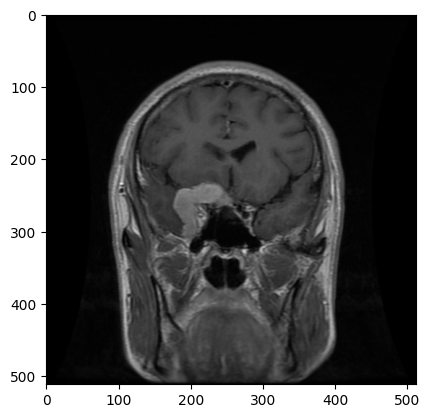

/home/minjung/final_project/training_masks/10.png
(512, 512)


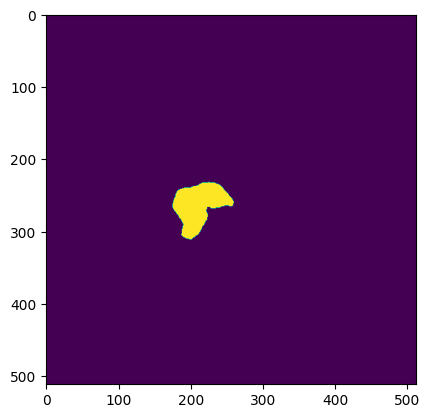

----------------------------------------------------
/home/minjung/final_project/training_images/100.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


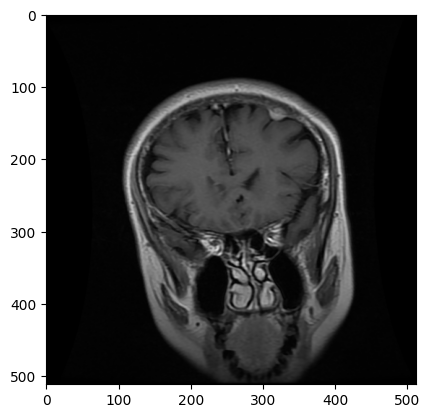

/home/minjung/final_project/training_masks/100.png
(512, 512)


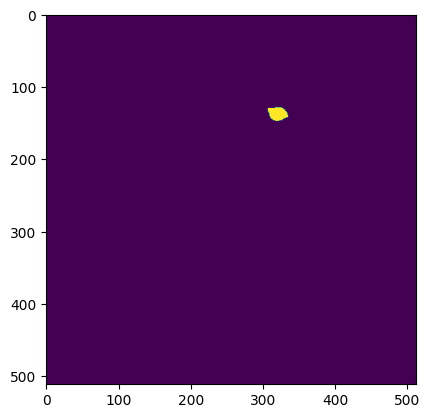

----------------------------------------------------


In [6]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.train,imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.train_mask,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

## Model

In [7]:
class CFG:
    device = torch.device("cuda:0")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 8
    epochs = 10000

In [8]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [x for x in permuted_train_img_lst]

/home/minjung/final_project/training_images/194.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


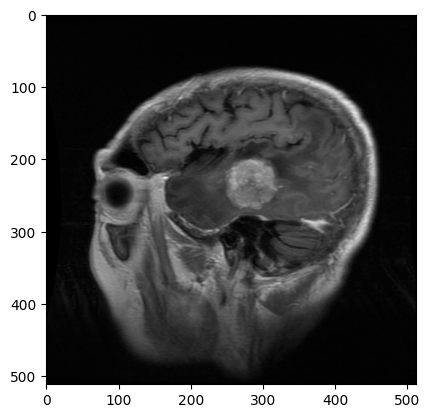

/home/minjung/final_project/training_masks/194.png
(512, 512)


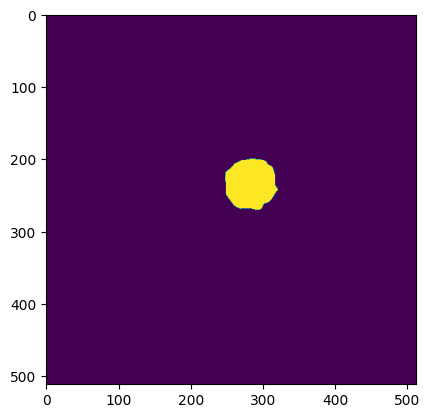

----------------------------------------------------
/home/minjung/final_project/training_images/182.png
(512, 512)
<class 'PIL.PngImagePlugin.PngImageFile'>


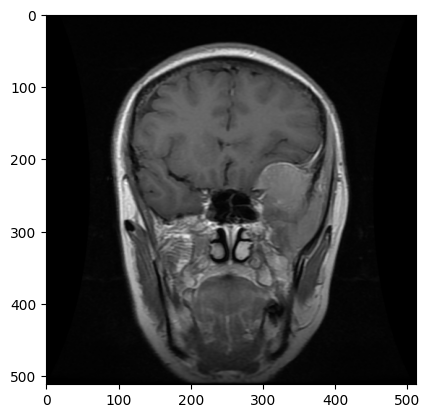

/home/minjung/final_project/training_masks/182.png
(512, 512)


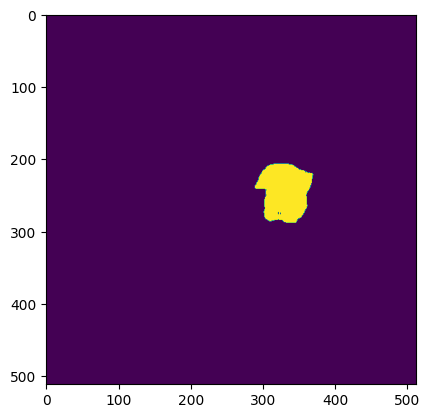

----------------------------------------------------


In [10]:
show_images(permuted_train_img_lst,permuted_train_mask_lst)

In [11]:
train_images_list = permuted_train_img_lst[int(CFG.split_pct*len(permuted_train_img_lst)) :]
train_masks_list = permuted_train_mask_lst[int(CFG.split_pct*len(permuted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = permuted_train_img_lst[: int(CFG.split_pct*len(permuted_train_img_lst))]
val_masks_list = permuted_train_mask_lst[: int(CFG.split_pct*len(permuted_train_mask_lst))]
print(len(val_masks_list))

305
76


In [12]:
class Dataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(ROOTDIR.train,self.img_list[index])
        mask_path = os.path.join(ROOTDIR.train_mask,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        #img_mask_dict = {"image": img, "mask": mask}

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            #transformations = self.transform(image=img, mask=mask)
            #img = transformations["image"]
            #mask = transformations["mask"]
            
        return img,mask

In [13]:
train_transform = A.Compose([A.Resize(512,512), 
                             A.HorizontalFlip(p=0.5),
                             A.ColorJitter(saturation=(0.2,3)),
                             A.Rotate(limit=30, p=0.5),
                             A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(512,512),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [14]:
train_dataset = Dataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = Dataset(val_images_list, val_masks_list, transform = train_transform)

In [15]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [16]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

In [17]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)

    def forward(self,x):
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)

        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)

        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

In [18]:
def iou_score(output, target):
    smooth = 1e-6

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

In [19]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    iou_score_total = 0

    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        mask = img_mask[1].float().to(CFG.device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        train_running_loss += loss.item() * CFG.batch_size
        loss.backward()
        optimizer.step()

        iou_score_total += iou_score(y_pred, mask)
        
    train_loss = train_running_loss / (j+1)
    avg_iou_score = iou_score_total / (j+1)

    return train_loss, avg_iou_score

In [20]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()

    val_running_loss = 0
    iou_score_total = 0

    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size

            iou_score_total += iou_score(y_pred, mask)
            
        val_loss = val_running_loss / (j+1)
        avg_iou_score = iou_score_total / (j+1)
    return val_loss, avg_iou_score

In [21]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice = dice_loss(torch.sigmoid(pred), target)
        loss = self.alpha * bce_loss + self.beta * dice
        return loss

In [22]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = CombinedLoss()
train_loss_lst = []
val_loss_lst = []  
train_iou_lst = []
val_iou_lst = []

## Training

In [23]:
# setting for early stopping
best_val_loss = float('inf')
patience = 15
counter_early_stop = 0
delta = 0.0001

# training
for i in tqdm(range(CFG.epochs)):
    train_loss, train_iou = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss, val_iou = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    train_iou_lst.append(train_iou)
    val_iou_lst.append(val_iou)
    
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        counter_early_stop = 0
    else:
        counter_early_stop += 1

    if counter_early_stop >= patience:
        print("Early stopping with best_val_loss: ", best_val_loss)
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 5.3127
 Validation Loss : 5.0716


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.8332
 Validation Loss : 4.7894


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.5683
 Validation Loss : 4.4848


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.3466
 Validation Loss : 4.2211


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 4.1070
 Validation Loss : 4.1001


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.9675
 Validation Loss : 3.9605


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.7655
 Validation Loss : 3.7424


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.5721
 Validation Loss : 3.7512


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.2783
 Validation Loss : 3.4038


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 3.0559
 Validation Loss : 2.9589


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.9474
 Validation Loss : 3.2915


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.7313
 Validation Loss : 2.8435


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.3971
 Validation Loss : 2.6556


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.2535
 Validation Loss : 2.5272


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.0613
 Validation Loss : 2.7048


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.8960
 Validation Loss : 2.1268


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 2.0214
 Validation Loss : 2.5826


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.8184
 Validation Loss : 2.3003


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.7354
 Validation Loss : 2.2043


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.5987
 Validation Loss : 2.2380


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.6652
 Validation Loss : 1.9110


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4954
 Validation Loss : 2.3951


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4434
 Validation Loss : 4.1361


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4017
 Validation Loss : 1.9514


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3423
 Validation Loss : 1.8122


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.4009
 Validation Loss : 1.6728


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.1956
 Validation Loss : 1.5937


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3468
 Validation Loss : 1.6692


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.2529
 Validation Loss : 3.0441


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.3511
 Validation Loss : 1.6590


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.1943
 Validation Loss : 2.9018


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.1674
 Validation Loss : 1.7051


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.1440
 Validation Loss : 2.4561


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.2082
 Validation Loss : 1.4958


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0040
 Validation Loss : 1.4829


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9691
 Validation Loss : 1.6806


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0519
 Validation Loss : 1.5849


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9438
 Validation Loss : 1.3853


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9147
 Validation Loss : 1.3725


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8129
 Validation Loss : 1.3895


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9098
 Validation Loss : 1.7445


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0690
 Validation Loss : 1.3250


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9464
 Validation Loss : 1.4444


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0225
 Validation Loss : 1.5198


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8385
 Validation Loss : 1.3268


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8754
 Validation Loss : 2.3074


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 1.0990
 Validation Loss : 1.4955


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8591
 Validation Loss : 1.7566


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8609
 Validation Loss : 1.8880


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8110
 Validation Loss : 1.3930


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8249
 Validation Loss : 1.3683


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8740
 Validation Loss : 1.4174


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8093
 Validation Loss : 1.9197


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9913
 Validation Loss : 1.4602


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.8485
 Validation Loss : 1.1833


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7678
 Validation Loss : 1.4346


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.9798
 Validation Loss : 1.4028


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7767
 Validation Loss : 1.3502


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6710
 Validation Loss : 1.3128


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7137
 Validation Loss : 1.8304


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7707
 Validation Loss : 1.0676


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7083
 Validation Loss : 1.3725


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7758
 Validation Loss : 1.1755


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7091
 Validation Loss : 1.1344


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7524
 Validation Loss : 1.1702


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6425
 Validation Loss : 1.3702


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7040
 Validation Loss : 1.4231


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7579
 Validation Loss : 2.3946


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7058
 Validation Loss : 1.2245


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6018
 Validation Loss : 1.4081


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6842
 Validation Loss : 1.2353


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6801
 Validation Loss : 1.0726


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6114
 Validation Loss : 0.9905


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5986
 Validation Loss : 1.2629


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5549
 Validation Loss : 1.0538


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6141
 Validation Loss : 1.2248


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5700
 Validation Loss : 1.0429


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5790
 Validation Loss : 0.9898


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6424
 Validation Loss : 1.1497


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5801
 Validation Loss : 0.9310


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5617
 Validation Loss : 1.1114


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.7446
 Validation Loss : 1.7769


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6183
 Validation Loss : 1.1098


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6640
 Validation Loss : 1.1412


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6339
 Validation Loss : 1.4135


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5818
 Validation Loss : 0.9868


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5489
 Validation Loss : 1.2745


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6029
 Validation Loss : 1.4182


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5895
 Validation Loss : 1.3023


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5742
 Validation Loss : 1.0229


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5434
 Validation Loss : 1.2880


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.5391
 Validation Loss : 1.3081


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6885
 Validation Loss : 0.9614


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6204
 Validation Loss : 1.1614


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 Train Loss : 0.6096
 Validation Loss : 1.0862
Early stopping with best_val_loss:  0.9309620648622513


## Training Graph

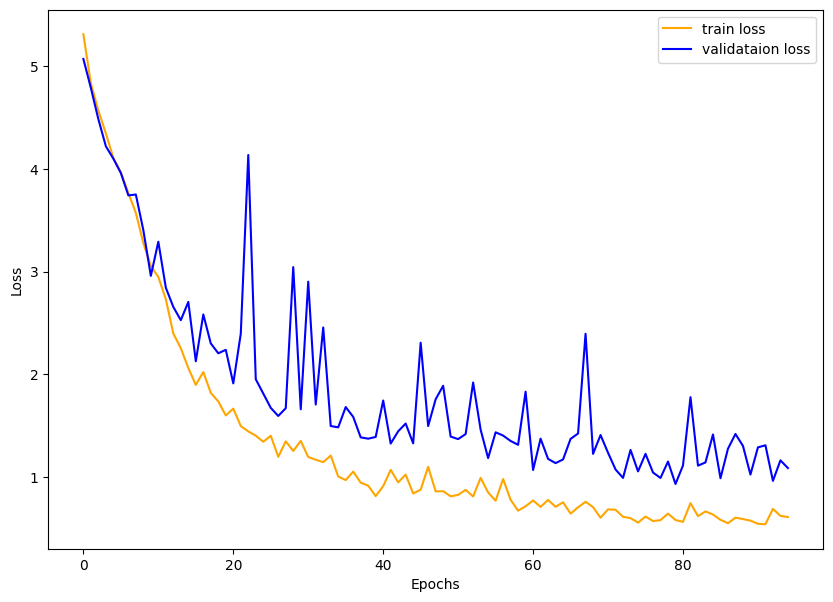

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss_lst, color='orange', label='train loss')
plt.plot(val_loss_lst, color='blue', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_graph.png') 
plt.show()

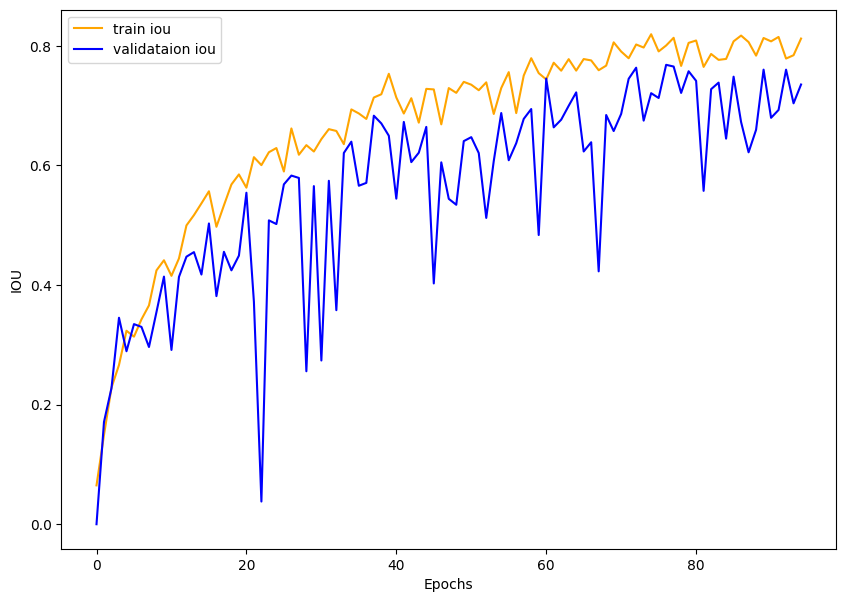

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(train_iou_lst, color='orange', label='train iou')
plt.plot(val_iou_lst, color='blue', label='validataion iou')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig('iou_graph.png') 
plt.show()

## Save Trained Model

In [26]:
TRAINED_FILE = "/home/minjung/final_project/unet_final_model_.pth"
torch.save(model.state_dict(), TRAINED_FILE)

## Inference

In [27]:
trained_model = UNET(in_chnls = 3, n_classes = 1)
UNET_TRAINED = "/home/minjung/final_project/unet_final_model_.pth"
trained_model.load_state_dict(torch.load(UNET_TRAINED))

<All keys matched successfully>

In [28]:
trained_model = trained_model.to("cuda:0")
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [29]:
test_transform = A.Compose([A.Resize(512,512),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [30]:
inference_img = os.listdir("/home/minjung/final_project/BrainTumor_image")

In [31]:
for i in inference_img:
    if(i.split('.')[-1]=='png'):
        print(i)
        path = "/home/minjung/final_project/BrainTumor_image/"
        img  = cv2.imread(path+i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        test_image = test_transform(image = img)
        img = test_image["image"].unsqueeze(0)
        img = img.to("cuda:0")
        pred = trained_model(img)
        mask = pred.squeeze(0).cpu().detach().numpy()
        mask[mask < 0]=0
        mask[mask > 0]=1
        mask = np.where(mask==1, 255, 0)
        mask = mask.astype(np.uint8)
        if(mask.shape==(1,512,512)):
            original_sized = cv2.resize(mask[0], dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        else:
            original_sized = cv2.resize(mask, dsize=(512,512), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite("/home/minjung/final_project/class1_class3_unet_inference_1205/"+i,original_sized)

1027.png
2091.png
1148.png
2257.png
2999.png
3053.png
515.png
1134.png
2145.png
2347.png
1683.png
2408.png
2770.png
1790.png
1064.png
1189.png
2592.png
2837.png
1114.png
901.png
1402.png
742.png
2718.png
2191.png
1972.png
318.png
29.png
251.png
1136.png
1458.png
1438.png
1821.png
1094.png
2087.png
126.png
2740.png
2469.png
121.png
1980.png
1281.png
2367.png
2511.png
793.png
407.png
492.png
391.png
2937.png
2505.png
1155.png
1340.png
2809.png
1286.png
999.png
2533.png
583.png
2203.png
1721.png
1806.png
61.png
315.png
2365.png
129.png
1887.png
2855.png
2192.png
1096.png
175.png
442.png
97.png
691.png
481.png
454.png
1585.png
81.png
1811.png
2746.png
564.png
92.png
2851.png
2148.png
947.png
2088.png
1397.png
837.png
1055.png
494.png
574.png
73.png
388.png
1657.png
1116.png
2017.png
1883.png
2667.png
42.png
236.png
1411.png
1531.png
2106.png
2899.png
167.png
2558.png
217.png
3023.png
17.png
1257.png
1694.png
2153.png
331.png
2992.png
998.png
2995.png
1676.png
71.png
2291.png
859.png
1194.p

## Check

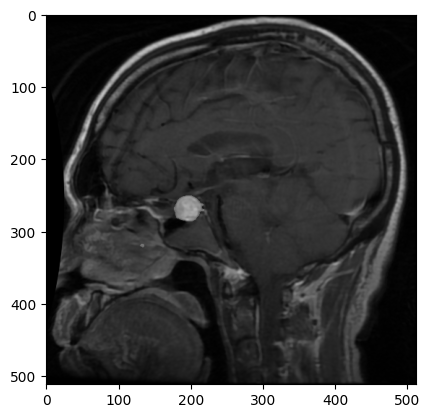

In [32]:
file_num = 3055

# 이미지 로드
image = cv2.imread('/home/minjung/final_project/BrainTumor_image/'+str(file_num)+'.png')
mask = cv2.imread('/home/minjung/final_project/class1_class3_unet_inference_class1_added/'+ str(file_num) +'.png', cv2.IMREAD_GRAYSCALE)

# 이미지와 마스크의 크기를 맞춰주기 위한 작업
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# 마스크를 3채널로 변환
mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# 투명도 적용을 위해 이미지와 마스크를 [0, 1] 범위로 정규화
image = image / 255.0
mask_colored = mask_colored / 255.0

# 투명도 (알파) 값 설정
alpha = 0.8

# 투명도를 적용한 마스크 이미지 생성
masked_image = (alpha * image) + ((1 - alpha) * mask_colored)

# 이미지 출력
plt.imshow(masked_image)
plt.show()